In [1]:
import numpy as np
import scipy as sp
import scipy.integrate as sp_int
import matplotlib.pyplot as plt
import matplotlib

In [56]:
# Set up the constants
C_m  = 1 # membrane capacitance (uF/cm^2)
g_Na = 120 # maximum conductances (mS/cm^2)
g_K  = 20
g_A  = 47.7
g_l  = 0.3
E_Na = 55 # reversal potentials (mV)
E_K  = -72
E_A = -75
E_l  = -17

In [127]:
# equations governing opening/closing rates.
MSHFT = -5.3
HSHFT = -12
NSHFT = -4.3
def a_n(V): return -0.01 * (V + 50 + NSHFT) / (np.exp(-(V + 50 + NSHFT)/10) - 1)
def b_n(V): return 0.125 * np.exp(-(V + 60 + NSHFT)/80)
def a_m(V): return -0.1 * (V + 35 + MSHFT) / (np.exp(-(V + 35 + MSHFT)/10) - 1)
def b_m(V): return 4 * np.exp(-(V + 60 + MSHFT)/18)
def a_h(V): return 0.07 * np.exp(-(V + 60 + HSHFT)/20)
def b_h(V): return 1 / (np.exp(-(V + 30 + HSHFT)/10 + 1))

In [128]:
# equations that determine the gating variables differential equations
def tau_n(V): return (2/3.8) / (a_n(V) + b_n(V))
def n_inf(V): return a_n(V) / (a_n(V) + b_n(V))
def tau_m(V): return (1/3.8) / (a_m(V) + b_m(V))
def m_inf(V): return a_m(V) / (a_m(V) + b_m(V))
def tau_h(V): return (1/3.8) / (a_h(V) + b_h(V))
def h_inf(V): return a_h(V) / (a_h(V) + b_h(V))
def A_inf(V): return (0.0761 * np.exp((V + 94.22)/31.84) / (1 + np.exp((V + 1.17) / 28.93)))**(1/3)
def tau_A(V): return 0.3632 + 1.158 / (1 + np.exp((V + 55.96) / 20.12))
def B_inf(V): return 1 / ((1 + np.exp((V + 53.3) / 14.54))**4)
def tau_B(V): return 1.24 + 2.678 / (1 + np.exp((V + 50) / 16.027))

In [129]:
# define the currents in the model
def I_Na(V, m ,h): return g_Na * (m**3) * h * (V - E_Na)
def I_K(V, n): return g_K * (n**4) * (V - E_K)
def I_A(V, A, B): return g_A * (A**3) * B * (V - E_A)
def I_l(V): return g_l * (V - E_l)

In [139]:
# define function that is time derivative of voltage: f = dV/dt
def f(t, y):
    # set external current: make sure it is 0 for large times.
    if 4 < t <= 5:
        I_e = 50
    else:
        I_e = 0
    # set the variables that are to be integrated
    V, n, m, h, A, B = y
    # define DV/dt ('_dot' denotes time differentiation)
    V_dot = 1/C_m * (I_e - (I_K(V, n) + I_Na(V, m, h) + I_A(V, A, B) + I_l(V)))

    # enter the equations controlling the gating variables.
    n_dot = (n_inf(V) - n) / tau_n(V)
    m_dot = (m_inf(V) - m) / tau_m(V)
    h_dot = (h_inf(V) - h) / tau_h(V)
    A_dot = (A_inf(V) - A) / tau_A(V)
    B_dot = (B_inf(V) - B) / tau_B(V)
    # since w = [V, n, m, h] we return [V_dot, n_dot, m_dot, h_dot, A_dot, B_dot]
    return [V_dot, n_dot, m_dot, h_dot, A_dot, B_dot]

In [140]:
# enter intial values for V, n, m, h
V_0 = -74
n_0 = 0.1
m_0 = 0.004
h_0 = 0.986
A_0 = 0.509
B_0 = 0.426
y_0 = [V_0, n_0, m_0, h_0, A_0, B_0]

In [141]:
# create timescale. t_interval is the time interval in which to calculate the solution.
# t_points are the points at which the solution is stored.
t_interval = (0.0, 100.0)
numpoints = 1000
t_points = np.linspace(t_interval[0], t_interval[1], numpoints)

In [142]:
# solve coupled ODEs with scipy's solver
soln = sp_int.solve_ivp(f, t_interval, y_0, 'RK45', t_points)

V = soln.y[0, :]
n = soln.y[1, :]
m = soln.y[2, :]
h = soln.y[3, :]
A = soln.y[4, :]
B = soln.y[5, :]

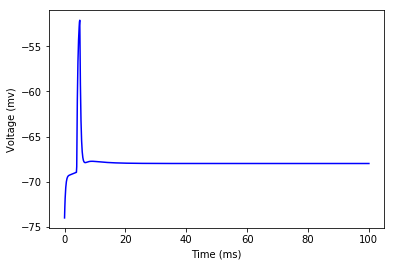

In [143]:
# plot & show solution
plt.plot(soln.t, soln.y[0, :], 'b')
plt.ylabel('Voltage (mv)')
plt.xlabel('Time (ms)')
plt.show()